In [1]:
import os
import sys
import pickle as pkl
import numpy as np
import scipy.io
import scipy.sparse as sp
from scipy.sparse import csgraph
import argparse
import logging
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.exceptions import UndefinedMetricWarning
import warnings
import pdb
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def load_adjacency_matrix(file, variable_name="network"):
    data = scipy.io.loadmat(file)
    return data[variable_name]


def load_label(file, variable_name="group"):
    data = scipy.io.loadmat(file)
    label = data[variable_name].todense().astype(np.int)
    label = np.array(label)
    return label

In [3]:
def construct_indicator(y_score, y):
    # rank the labels by the scores directly
    num_label = np.sum(y, axis=1, dtype=np.int)
    y_sort = np.fliplr(np.argsort(y_score, axis=1))
    y_pred = np.zeros_like(y, dtype=np.int)
    for i in range(y.shape[0]):
        for j in range(num_label[i]):
            y_pred[i, y_sort[i, j]] = 1
    return y_pred

In [4]:
def predict_cv(X, y, train_ratio=0.2, n_splits=10, random_state=0, C=1.):
    shuffle = ShuffleSplit(n_splits=n_splits, test_size=1-train_ratio,
            random_state=random_state)
    result = [0] * X.shape[0]
    count = 0
    for train_index, test_index in shuffle.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = OneVsRestClassifier(
                LogisticRegression(
                    C=C,
                    solver="liblinear",
                    multi_class="ovr"),
                n_jobs=-1)
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
        y_pred = construct_indicator(y_score, y_test)
        for i in range(len(test_index)):
            if (y_pred[i] == y[test_index[i]]).all():
                result[test_index[i]] += 1
        count += 1
    return [i / count for i in result]

In [9]:
def load_data(name):
    embedding = np.load('../../data/embeded/' + name + '.npy')
    data = scipy.io.loadmat('../../data/proximity/' + name + '.mat')
    matrix = sp.csr_matrix(data[list(data.keys())[-1]])
    degree = np.array(matrix.sum(axis=0))[0]
    colors = load_label('../../data/origin/Homo_sapiens.mat')
    return embedding, degree, colors

In [10]:
def precision_degree(name):
    embedding, degree, colors = load_data(name)
    precision = predict_cv(embedding, colors)
    plt.clf()
    plt.scatter(degree, precision, s=0.8)
    plt.xlabel('degree')
    plt.ylabel('precision')
    plt.title(name)
    plt.savefig(name + '.png')

In [11]:
n = ['invlap', 'HOPE', 'netmf', 'heat', 'FaBP']
names = []
for name in n:
    names.append(name)
    names.append(name + '_l')
    names.append(name + '_b1')
    names.append(name + '_b2')
print(names)
print(len(names))

['invlap', 'invlap_l', 'invlap_b1', 'invlap_b2', 'HOPE', 'HOPE_l', 'HOPE_b1', 'HOPE_b2', 'netmf', 'netmf_l', 'netmf_b1', 'netmf_b2', 'heat', 'heat_l', 'heat_b1', 'heat_b2', 'FaBP', 'FaBP_l', 'FaBP_b1', 'FaBP_b2']
20


1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20


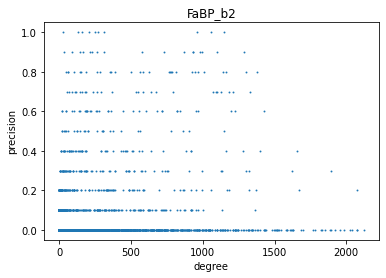

In [12]:
c = 0
for name in names:
    precision_degree(name)
    c += 1
    print(c,'/',len(names))